In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
birdnet_file = 'BirdNET_Soundscape_Model.pkl'

In [3]:
NONLINEARITY = 'relu'
FILTERS = [8, 16, 32, 64, 128]
KERNEL_SIZES = [(5, 5), (3, 3), (3, 3), (3, 3), (3, 3)]
RESNET_K = 4
RESNET_N = 3

In [4]:
with open(birdnet_file, 'rb') as f:
    loaded_model = pickle.load(f, encoding='latin1')

In [5]:
def without_keys(d, keys):
    return {x: d[x] for x in d if x not in keys}

In [6]:
model_params = without_keys(loaded_model, ['classes', 'params', 'confidence_thresholds'])#.keys()

In [7]:
model_params

{'im_dim': 1,
 'spec_fmin': 150,
 'spec_fmax': 15000,
 'zero_centered_normalization': False,
 'win_len': 512,
 'sample_rate': 48000,
 'spec_type': 'melspec',
 'magnitude_scale': 'nonlinear',
 'spec_length': 3.0,
 'im_size': (384, 64)}

In [8]:
classes = loaded_model['classes']

In [9]:
classes_names = [c.split('_')[1] for c in classes]

In [10]:
classes_names_sort = classes_names
classes_names_sort.sort()

In [11]:
len(classes_names_sort)

987

In [12]:
for c in classes_names_sort:
    if 'Gull' in c:
        print(c)

Audouin's Gull
Black-headed Gull
Bonaparte's Gull
California Gull
Caspian Gull
Franklin's Gull
Glaucous Gull
Glaucous-winged Gull
Great Black-backed Gull
Gull-billed Tern
Heermann's Gull
Herring Gull
Laughing Gull
Lesser Black-backed Gull
Little Gull
Mediterranean Gull
Mew Gull
Pallas's Gull
Ring-billed Gull
Ross's Gull
Sabine's Gull
Slender-billed Gull
Western Gull
Yellow-legged Gull


In [13]:
import os
rich_classes = os.listdir('richfield_birds_split')

In [14]:
#rich_classes[1] = 'Eurasian Kestrel'
#rich_classes[4] = 'Herring Gull'
rich_classes

['Common Buzzard',
 'Common Kestrel',
 'Common Snipe',
 'Eurasian Curlew',
 'European Herring Gull',
 'European Robin',
 'Meadow Pipit',
 'Mute Swan',
 'Northern Lapwing',
 'Rook',
 'Tundra Swan',
 'Tundra Swan (Bewicks)']

In [15]:
sub_classes = [c for c in classes_names if c in rich_classes]
sub_classes

['Common Buzzard',
 'Common Snipe',
 'Eurasian Curlew',
 'European Robin',
 'Meadow Pipit',
 'Mute Swan',
 'Northern Lapwing',
 'Rook',
 'Tundra Swan']

In [16]:
l_params = loaded_model['params']

In [17]:
#loaded_model['im_size']

In [18]:
#loaded_model.keys()

In [19]:
def input_layer_fn(x):
    return (x['im_size'][0], x['im_size'][1], x['im_dim'])
input_shape = input_layer_fn(loaded_model)

In [20]:
import tensorflow as tf
from tensorflow.keras import layers

In [21]:
#input_layer_fn(loaded_model)

In [22]:
def logmeanexp(x, axis = 1, keepdims = False, sharpness = 5):
    # in between maximum (high sharpness) and mean (low sharpness)
    # https://arxiv.org/abs/1411.6228, Eq. 6
    # return T.log(T.mean(T.exp(sharpness * x), axis, keepdims=keepdims)) / sharpness
    # more stable version (Theano can only stabilize the plain logsumexp)
    xmax  = tf.reduce_max(x, axis, keepdims=True)
    xmax2 = tf.reduce_min(x, axis, keepdims=keepdims)
    x = sharpness * (x - xmax)
    y = tf.math.log(tf.reduce_mean(tf.math.exp(x), axis, keepdims=keepdims))
    y = y / sharpness + xmax2
    return y

In [23]:
def resblock(net_in, filters, kernel_size, stride=1, preactivated=True, block_id=1, name=''):

    # Pre-activation
    if block_id > 1:
        net_pre = tf.keras.layers.ReLU()(net_in)
    else:
        net_pre = net_in

    # Pre-activated shortcut?
    if preactivated:
        net_in = net_pre

    # Bottleneck Convolution
    if stride > 1:
        net_pre = layers.Conv2D(net_pre.shape[-1], 
                                kernel_size = 1,
                                padding     = 'same',
                                activation  = 'relu')(net_pre)
        net_pre = layers.BatchNormalization()(net_pre)
    
    # First Convolution     
    net = layers.Conv2D(net_pre.shape[-1], 
                        kernel_size = kernel_size,
                        padding     = 'same',
                        activation  = 'relu')(net_pre)
    net = layers.BatchNormalization()(net)

    # Pooling layer
    if stride > 1:
        net = layers.MaxPooling2D(pool_size=(stride, stride))(net)

    # Dropout Layer
    net = layers.Dropout(0.5)(net)        

    # Second Convolution
    net = layers.Conv2D(filters, 
                        kernel_size = kernel_size,
                        padding     = 'same')(net)
    net = layers.BatchNormalization()(net)
    
    # Shortcut Layer
    if not net.shape.as_list() == net_in.shape.as_list():

        # Average pooling
        shortcut = layers.AveragePooling2D(pool_size=(stride, stride), strides=stride)(net_in)

        # Shortcut convolution
        shortcut = layers.Conv2D(filters, 
                                 kernel_size = 1,
                                 padding     = 'same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
        
    else:
        # Shortcut = input
        shortcut = net_in
    
    # Merge Layer
    out = layers.Add()([net, shortcut])
    
    return out

In [24]:
def classificationBranch(net, kernel_size):

    # Post Convolution
    x = layers.Conv2D(int(FILTERS[-1] * RESNET_K), kernel_size,
                  #padding     = 'same',
                  activation  = 'relu')(net)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    # Dense Convolution
    x = layers.Conv2D(int(FILTERS[-1] * RESNET_K * 2), 1,
                  #padding     = 'same',
                  activation  = 'relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    # Class Convolution
    x = layers.Conv2D(len(classes_names), 1,
                      activation  = 'relu')(x)
    x = layers.Flatten()(x)
    #x = layers.MaxPooling2D(pool_size=(x.shape[1], x.shape[2]))(x)
    x = layers.Dense(len(sub_classes))(x) #classes_names
    return x

In [25]:
def buildNet(input_shp):
    net_shape = loaded_model['im_size']

    # Input layer for images
    input_net = tf.keras.Input(input_shp)
    
    net = layers.Resizing(net_shape[0], net_shape[1])(input_net)

    # Pre-processing stage
    net = layers.Conv2D(int(FILTERS[0] * RESNET_K), 5,
                        padding = 'same',
                        activation  = 'relu')(net)
    net = layers.BatchNormalization()(net)
    
    # Max pooling
    net = layers.MaxPooling2D(pool_size=(2, 1))(net)

    # Residual Stacks
    for i in range(1, len(FILTERS)):
        #print("i",i)
        net = resblock(net,
                       filters=int(FILTERS[i] * RESNET_K),
                       kernel_size=KERNEL_SIZES[i],
                       stride=2,
                       preactivated=True,
                       block_id=i,
                       name='BLOCK ' + str(i) + '-1')
        
        for j in range(1, RESNET_N):
            #print("j",j)
            net = resblock(net,
                           filters=int(FILTERS[i] * RESNET_K),
                           kernel_size=KERNEL_SIZES[i],
                           preactivated=False,
                           block_id=i+j,
                           name='BLOCK ' + str(i) + '-' + str(j + 1))
    
    # Post Activation
    net = layers.BatchNormalization()(net)
    net = layers.ReLU()(net)
    
    # Classification branch
    net = classificationBranch(net,  (10, 4)) 
    
    # Pooling
    #net = layers.GlobalAveragePooling2D()(net)
    #net = layers.Lambda(logmeanexp)(net)
    #net = layers.Lambda(tf.squeeze)(net)
    
    # Sigmoid output
    out = layers.Softmax()(net)
    
    out = tf.keras.Model(inputs = input_net, outputs = out)
    return out

In [26]:
birdnet_model = buildNet((100, 180, 1))

In [27]:
type(birdnet_model)

keras.engine.functional.Functional

In [28]:
birdnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 180, 1) 0                                            
__________________________________________________________________________________________________
resizing (Resizing)             (None, 384, 64, 1)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 384, 64, 32)  832         resizing[0][0]                   
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 384, 64, 32)  128         conv2d[0][0]                     
______________________________________________________________________________________________

In [29]:
#Check parameters and try load theano/lasagne ones into it

In [30]:
model_config = birdnet_model.get_config()

C:\Users\Anthony\Anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [31]:
i=0
conv_layer_indices = []
bn_layer_indices   = []
for layer in birdnet_model.layers:
    if layer.name.startswith('conv'):
        conv_layer_indices.append(i)
    if layer.name.startswith('batch_norm'):
        bn_layer_indices.append(i)
    #print(i)
    i += 1
    #print(layer.name)
    #lyr = layer.get_weights()
    #if(len(lyr)==0):
    #    print(lyr)
    #else:
    #    print(lyr[0].shape)
    #    print(lyr[1].shape)
    #    if layer.name.startswith('batch_norm'):
    #        print(lyr[2].shape)
    #        print(lyr[3].shape)

In [32]:
i=0
conv_layer_indices_params = []
bn_layer_indices_params   = []
for p in l_params:#[0].shape
    #print(i)
    if len(p.shape) == 4:
        conv_layer_indices_params.append(i)
        bn_layer_indices_params.append(i+1)
        if i+5 < len(l_params) and not len(l_params[i+5].shape) == 4:
            bn_layer_indices_params.append(i+5)
        #print(p.transpose().shape)
    #else:
        #print(p.shape)
    i += 1
bn_layer_indices_params = bn_layer_indices_params[:-1]

In [33]:
#Check batch norm shapes to copy are equal
#for i in range(len(bn_layer_indices)):
#    lyr = birdnet_model.layers[bn_layer_indices[i]].get_weights()
#    if(len(lyr)==0):
#        print(bn_layer_indices[i], 
#              lyr,'-',
#              bn_layer_indices_params[i], 
#              l_params[bn_layer_indices_params[i]].shape)
#    else:
#        print(bn_layer_indices[i], 
#              lyr[0].shape,'-',
#              bn_layer_indices_params[i],
#              l_params[bn_layer_indices_params[i]].shape)   

In [34]:
def copy_conv_weights(model, l_params, tf_indices, param_indices):
    conf = model.get_config()
    layer_names = [conf['layers'][x]['config']['name'] for x in range(len(conf['layers']))]
    conv_layer_names = [x for x in layer_names if x.startswith('conv')]
    for idx, layer in enumerate(model.layers):
        if layer.name in conv_layer_names:
            idy = param_indices[tf_indices.index(idx)]
            #print(l_params[idy].transpose().shape)
            #print(l_params[idy+1].transpose().shape)
            #layer.set_weights([l_params[idy].transpose(),params[idy+1].transpose()])
            layer.set_weights([l_params[idy].transpose(),tf.zeros(l_params[idy+1].transpose().shape)])

In [35]:
#layer.set_weights([l_params[idy].transpose(),tf.zeros(l_params[idy+1].transpose().shape)])

In [36]:
#batch norm weights
def copy_bn_weights(model, l_params, tf_indices, param_indices):
    conf = model.get_config()
    layer_names = [conf['layers'][x]['config']['name'] for x in range(len(conf['layers']))]
    bn_layer_names = [x for x in layer_names if x.startswith('batch_norm')]
    #print(bn_layer_names)
    for idx, layer in enumerate(model.layers):
        if layer.name in bn_layer_names:
            #print('idx',idx)
            #print('tf_indices.index(idx)',tf_indices.index(idx))
            #print(param_indices[tf_indices.index(idx)])
            idy = param_indices[tf_indices.index(idx)]
            layer.set_weights([l_params[idy], l_params[idy+1], l_params[idy+2], l_params[idy+3]])

In [37]:
copy_conv_weights(birdnet_model, l_params, conv_layer_indices, conv_layer_indices_params)

In [38]:
copy_bn_weights(birdnet_model, l_params, bn_layer_indices, bn_layer_indices_params)

## Get spec data from helper functions

In [39]:
from tf_helpers import main_cnn, plotly_cm, multify_weights, copy_weights_tl, concat_model, concat_model2, concat_model3, concat_model4

In [40]:
model_params

{'im_dim': 1,
 'spec_fmin': 150,
 'spec_fmax': 15000,
 'zero_centered_normalization': False,
 'win_len': 512,
 'sample_rate': 48000,
 'spec_type': 'melspec',
 'magnitude_scale': 'nonlinear',
 'spec_length': 3.0,
 'im_size': (384, 64)}

In [41]:
48000/50

960.0

In [42]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)

    # Note: You'll use indexing here instead of tuple unpacking to enable this 
    # to work in a TensorFlow graph.
    return parts[-2]

def gen_complex_spec(waveform, sr):
    #nfft     = int(0.02*float(sr)) #params.fft_win_length
    nfft     = model_params['win_len'] #48000//50 #params.fft_win_length
    #noverlap = int(0.1*nfft) #params.fft_overlap
    noverlap = nfft//10 #params.fft_overlap
    
    # window data
    step    = nfft - noverlap
    #step = 2**12
    waveform = tf.cast(waveform, tf.float32)
    
    # produces an array of complex numbers representing magnitude and phase
    complex_spec = tf.signal.stft(
        waveform, frame_length=nfft, frame_step=step)
    return complex_spec

def multi_spec_stack(complex_spec, choices = ['Mod'], stack = True):
    #possible components:
    ##Mod    modulus/absolute value (regular)
    ##Re     real component
    ##AbsRe  abs(real component)
    ##Im     imaginary component
    ##AbsIm  abs(imaginary component)
    ##Ang    angular componant
    ##AbsAng abs(angular componant)
    spec_arr = []
    for c in choices:
        def apply_func(x,c):
            if c == 'Mod':
                return tf.math.abs(x)
            if c == 'LogMod':
                return tf.math.log(tf.math.abs(x)+np.finfo(np.float32).eps)
            if c == 'Re':
                return tf.math.real(x)
            if c == 'AbsRe':
                return tf.math.abs(tf.math.real(x))
            if c == 'LogAbsRe':
                return tf.math.log(tf.math.abs(tf.math.real(x))+np.finfo(np.float32).eps)
            if c == 'Im':
                return tf.math.imag(x)
            if c == 'AbsIm':
                return tf.math.abs(tf.math.imag(x))
            if c == 'LogAbsIm':
                return tf.math.log(tf.math.abs(tf.math.imag(x))+np.finfo(np.float32).eps)
            if c == 'Ang':
                return tf.math.angle(x)
            if c == 'AbsAng':
                return tf.math.abs(tf.math.angle(x))
        spec_arr.append(apply_func(complex_spec,c))
    if stack:
        spec_arr = tf.stack(spec_arr,-1)
    return spec_arr

def multi_spec_post(spec, req_width, spec_norm, resize):
    spec_shp         = tf.shape(spec)
    spec_cutoff      = [0, 1, 0]
    spec_cutoff_size = [spec_shp[0],spec_shp[1]-1, spec_shp[2]]
    spec             = tf.slice(spec, spec_cutoff, spec_cutoff_size)
    
    # only keep the relevant bands - could do this outside
    #spec = spec[:, :100, :]
    
    spec_shp  = tf.shape(spec)
    req_width = req_width*resize
    
    if spec_shp[0] < tf.constant(req_width):
        zero_pad = tf.ones((tf.constant(req_width) - spec_shp[0], spec_shp[1], spec_shp[2]))*1e-8
        spec     = tf.concat([spec, zero_pad], axis = 0)
    else:
        spec = tf.slice(spec, [0,0,0], [req_width, spec_shp[1], spec_shp[2]]) #spec[:,:req_width,:]
        
    spec = tf.transpose(spec, perm = [1,0,2])
    
    def spec_normalize(x):
        out_tf = 255*(x - tf.math.reduce_min(x,axis=(0,1), keepdims=True)) / (tf.math.reduce_max(x,axis=(0,1), keepdims=True) - tf.math.reduce_min(x,axis=(0,1), keepdims=True)+np.finfo(np.float32).eps) 
        #out_tf = (x - tf.math.reduce_mean(x,axis=(0,1), keepdims=True)) / (tf.math.reduce_std(x,axis=(0,1), keepdims=True) +np.finfo(np.float32).eps)
        return out_tf
        
    if spec_norm:
        spec = spec_normalize(spec)
    
    return spec

def spec_unstack(spec,label):
    spec = tf.stack(spec)
    #spec = tf.unstack(spec, axis=-1)
    spec = tf.data.Dataset.zip(tuple([tf.expand_dims(x_ind, axis=-1) for x_ind in spec]))
    return spec, label

def decode_audio(audio_binary):
    audio, sr = tf.audio.decode_wav(audio_binary) # returns the WAV-encoded audio as a tensor and the sample rate
    #return tf.squeeze(audio, axis=-1) # removes dimensions of size 1 from the last axis
    #sr = sr // 5
    return audio[:,0], sr#.numpy()

def get_waveform_sr_and_label(file_path):
    label         = get_label(file_path)
    audio_binary  = tf.io.read_file(file_path)
    waveform, sr  = decode_audio(audio_binary)
    aud_tuple     = (waveform, sr)
    return aud_tuple, label

def get_spectrogram_and_label_id(audio, label, choices, categories, req_width, single_to_rgb, resize, spec_norm):
    #spectrogram = get_complex_spectrogram(audio)
    #print(dir(audio))
    aud, sr      = audio
    complex_spec = gen_complex_spec(aud, sr)
    multi_spec   = multi_spec_stack(complex_spec, choices)
    multi_spec   = multi_spec_post(multi_spec, req_width, spec_norm, resize)
    if single_to_rgb:
        multi_spec = tf.concat([multi_spec,multi_spec,multi_spec], axis=-1)
        multi_spec = tf.stack(multi_spec)
    #multi_spec = complex_spec
    spec_shape = tf.shape(multi_spec)
    if resize > 1:
        multi_spec = tf.image.resize(multi_spec, [spec_shape[0]//resize, spec_shape[1]//resize])
    label_id   = tf.argmax(label == categories)
    return multi_spec, label_id

def preprocess_dataset(files, choices, categories, req_width = 250, single_to_rgb = False, resize = 1, spec_norm = False):
    AUTOTUNE  = tf.data.experimental.AUTOTUNE
    files_ds  = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_waveform_sr_and_label, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(lambda x,y : get_spectrogram_and_label_id(audio=x, label=y,  choices = choices, 
        categories = categories, req_width = req_width, single_to_rgb = single_to_rgb, resize = resize, spec_norm = spec_norm), 
    num_parallel_calls=AUTOTUNE)
    #output_ds = output_ds.map(lambda x,y : spec_unstack(spec=x, label=y), num_parallel_calls=AUTOTUNE)
    return output_ds

def get_wf_dataset(files):
    AUTOTUNE  = tf.data.experimental.AUTOTUNE
    files_ds  = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_waveform_sr_and_label, num_parallel_calls=AUTOTUNE)
    return output_ds

In [43]:
#data_dir = pathlib.Path('/root/tensorflow_datasets/downloads/extracted/TAR_GZ.opihi.cs.uvic.ca_sound_music_speechbya81rFcWfLSW6ey5cynqyeq2qiePcL-7asMoNO6IQ0.tar.gz/music_speech')
data_dir   = 'richfield_birds_split'#'dublin_dl_birds_split'#
#categories = np.array(tf.io.gfile.listdir(data_dir))
#categories = [category for category in categories if 'wav' not in category]
#categories

In [44]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)

    # Note: You'll use indexing here instead of tuple unpacking to enable this 
    # to work in a TensorFlow graph.
    return parts[-2]

In [45]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
#filenames = tf.io.gfile.glob('birds/*/*')
filenames = [filename for filename in filenames if 'wav' in filename and get_label(filename) in sub_classes]
filenames = tf.random.shuffle(filenames)

In [46]:
all_labs = [get_label(y).numpy().decode() for y in filenames]
filename_df = pd.DataFrame({'name': filenames.numpy(),
                            'label': all_labs
                           })

In [47]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(filename_df, test_size=0.2, stratify=filename_df[['label']])
train_files = tf.random.shuffle(train['name'])
test_files  = tf.random.shuffle(test['name'])

In [48]:
#categories

In [51]:
train_labs = [tf.argmax(get_label(y) == rich_classes) for y in train_files]
test_labs  = [tf.argmax(get_label(y) == rich_classes) for y in test_files]
train_labs_sort = train_labs
test_labs_sort  = test_labs
train_labs_sort.sort()
test_labs_sort.sort()

Text(0.5, 1.0, 'Test')

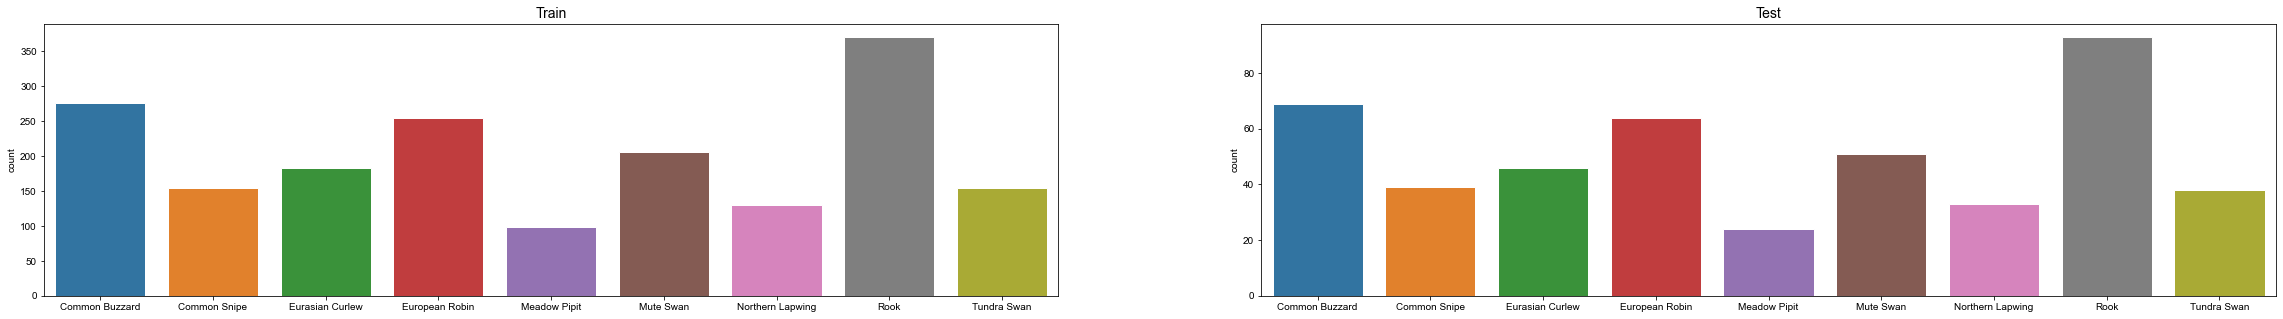

In [52]:
f, axes = plt.subplots(1, 2, figsize = (40,5))
l = []
for i in train_labs_sort:
    l.append(rich_classes[i])
sns.set_style('darkgrid')
sns.countplot(x = l, ax=axes[0])
lb = axes[0].get_xlabel()
axes[0].set_xlabel(lb, fontsize=8)
axes[0].set_title("Train", size = 14)

lt = []
for i in test_labs_sort:
    lt.append(rich_classes[i])
sns.set_style('darkgrid')
sns.countplot(x = lt, ax=axes[1])
lbt = axes[1].get_xlabel()
axes[1].set_xlabel(lbt, fontsize=10)
axes[1].set_title("Test", size = 14)

In [53]:
train_ds_mult = preprocess_dataset(train_files, choices=['Mod'], categories=sub_classes, req_width=200)
test_ds_mult  = preprocess_dataset(test_files,  choices=['Mod'], categories=sub_classes, req_width=200)

In [54]:
X_train = [x for x,y in train_ds_mult]
y_train = [y for x,y in train_ds_mult]
X_test  = [x for x,y in test_ds_mult]
y_test  = [y for x,y in test_ds_mult]

In [55]:
#[classes_names.index(get_label(c)) if get_label(c) in classes_names else -1 for c in test_files]
[sub_classes.index(get_label(c)) if get_label(c) in sub_classes else -1 for c in test_files]

[7,
 2,
 8,
 5,
 4,
 4,
 7,
 8,
 8,
 5,
 7,
 0,
 5,
 4,
 5,
 7,
 7,
 7,
 0,
 2,
 4,
 3,
 3,
 0,
 3,
 3,
 3,
 0,
 2,
 7,
 7,
 0,
 5,
 0,
 3,
 4,
 3,
 3,
 0,
 0,
 2,
 6,
 7,
 5,
 7,
 0,
 3,
 2,
 8,
 3,
 3,
 1,
 7,
 3,
 7,
 1,
 7,
 3,
 0,
 1,
 7,
 0,
 8,
 7,
 2,
 5,
 0,
 7,
 6,
 7,
 7,
 2,
 2,
 5,
 5,
 1,
 8,
 5,
 7,
 5,
 7,
 0,
 1,
 3,
 6,
 3,
 5,
 4,
 2,
 2,
 5,
 5,
 7,
 7,
 8,
 0,
 6,
 7,
 3,
 3,
 7,
 4,
 5,
 6,
 7,
 8,
 7,
 3,
 7,
 3,
 1,
 3,
 5,
 6,
 7,
 5,
 7,
 5,
 7,
 0,
 2,
 2,
 0,
 7,
 8,
 0,
 7,
 4,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 4,
 0,
 1,
 8,
 5,
 1,
 3,
 8,
 1,
 3,
 0,
 7,
 0,
 0,
 7,
 8,
 6,
 4,
 7,
 1,
 8,
 2,
 3,
 3,
 7,
 6,
 3,
 6,
 6,
 3,
 7,
 6,
 2,
 7,
 2,
 6,
 3,
 7,
 7,
 2,
 6,
 7,
 7,
 8,
 7,
 3,
 7,
 6,
 7,
 0,
 2,
 2,
 0,
 3,
 7,
 0,
 3,
 0,
 6,
 5,
 7,
 7,
 5,
 5,
 0,
 2,
 0,
 6,
 0,
 6,
 5,
 1,
 0,
 8,
 6,
 3,
 5,
 1,
 6,
 0,
 0,
 3,
 6,
 1,
 3,
 2,
 1,
 1,
 0,
 7,
 1,
 3,
 7,
 0,
 7,
 6,
 2,
 7,
 3,
 7,
 2,
 5,
 3,
 7,
 0,
 1,
 0,
 4,
 7,
 2,
 5,
 3,
 5,


In [56]:
#y_test

In [57]:
for spec, lab in train_ds_mult.take(1):
    spec = spec
    input_shape = tf.expand_dims(spec[:,:,0], axis=-1).shape
    print(input_shape)
    print(classes_names[lab])

(256, 200, 1)
Alder Flycatcher


In [58]:
spec.shape

TensorShape([256, 200, 1])

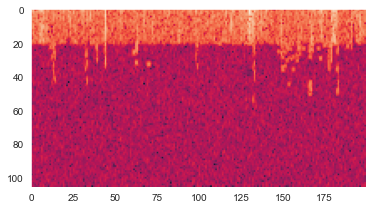

In [59]:
plt.imshow(np.log(spec[150:,:300,0]))
plt.grid(False)

In [60]:
AUTOTUNE   = tf.data.experimental.AUTOTUNE
batch_size = 32
train_ds_mult = train_ds_mult.batch(batch_size)
test_ds_mult  = test_ds_mult.batch(batch_size)
train_ds_mult = train_ds_mult.cache().prefetch(AUTOTUNE)
test_ds_mult  = test_ds_mult.cache().prefetch(AUTOTUNE)

In [61]:
birdnet_model.compile(
    optimizer = tf.optimizers.Adam(learning_rate=0.0001),
    loss      = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics   = 'accuracy'
    )

In [62]:
for lyr in birdnet_model.layers:
    lyr.trainable = False
for lyr in birdnet_model.layers[-5:]:
    if lyr.name.startswith('dense') or lyr.name.startswith('conv'):
        lyr.trainable = True

In [63]:
birdnet_model.layers[-5:]

In [64]:
#tf.stack(X_test)

In [65]:
birdnet_model.evaluate(test_ds_mult)

15/15 [==============================] - 15s 919ms/step - loss: nan - accuracy: 0.1510


[nan, 0.15098468959331512]

In [66]:
#birdnet_model.fit(train_ds_mult, )
history = birdnet_model.fit(train_ds_mult,
                    validation_data = test_ds_mult,
                    epochs          = 10)

Epoch 1/10
57/57 [==============================] - 257s 4s/step - loss: 2.1972 - accuracy: 0.1886 - val_loss: 2.1971 - val_accuracy: 0.2035
Epoch 2/10
 6/57 [==>...........................] - ETA: 4:47 - loss: 2.1971 - accuracy: 0.1719

KeyboardInterrupt: 